In [1]:
import video_processing as vp
import animation

### Define some static global variables

In [ ]:
WIDTH = 256
HEIGHT = 256
TRUE_FRAMERATE = 28.815
BEHAVIOUR_FRAMERATE = 1/(11090.9/1e6)

In [ ]:
l_mouse = 
r_mouse = 

### Extract the color channels from the RAW files

In [ ]:
l_mouse_green_frames = vp.extract_channel(
    filename=l_mouse,
    channel='green',
    width=WIDTH,
    height=HEIGHT
)

r_mouse_green_frames = vp.extract_channel(
    filename=r_mouse,
    channel='green',
    width=WIDTH,
    height=HEIGHT
)

l_mouse_blue_frames = vp.extract_channel(
    filename=l_mouse,
    channel='blue',
    width=WIDTH,
    height=HEIGHT
)

r_mouse_blue_frames = vp.extract_channel(
    filename=r_mouse,
    channel='blue',
    width=WIDTH,
    height=HEIGHT
)

l_mouse_red_frames = vp.extract_channel(
    filename=l_mouse,
    channel='red',
    width=WIDTH,
    height=HEIGHT
)

r_mouse_red_frames = vp.extract_channel(
    filename=r_mouse,
    channel='red',
    width=WIDTH,
    height=HEIGHT
)

### Import RAW timestamps and clean the data

In [ ]:
l_mouse_timestamps = vp.clean_raw_timestamps(l_mouse_timestamps_raw)
r_mouse_timestamps = vp.clean_raw_timestamps(r_mouse_timestamps_raw)

### Remove dark frames

In [ ]:
# slice by threshold on green frames
l_mouse_slice = vp.DarkFramesSlice.threshold_method(
    frames=l_mouse_green_frames
)
r_mouse_slice = vp.DarkFramesSlice.threshold_method(
    frames=r_mouse_green_frames
)

# slice green frames
l_mouse_green_frames = l_mouse_green_frames[l_mouse_slice]
r_mouse_green_frames = r_mouse_green_frames[r_mouse_slice]

# slice blue frames
l_mouse_blue_frames = l_mouse_blue_frames[l_mouse_slice]
r_mouse_blue_frames = r_mouse_blue_frames[r_mouse_slice]

# slice timestamps
l_mouse_timestamps = l_mouse_timestamps[l_mouse_slice]
r_mouse_timestamps = r_mouse_timestamps[r_mouse_slice]

### Find locations of any dropped frames

In [ ]:
l_mouse_delta, l_mouse_where_dropped = vp.get_locations_of_dropped_frames(
    timestamps=l_mouse_timestamps,
    fps=30
)

r_mouse_delta, r_mouse_where_dropped = vp.get_locations_of_dropped_frames(
    timestamps=r_mouse_timestamps,
    fps=30
)

### Fill in dropped frames by interpolating available data

In [ ]:
# Create a list of DroppedFrames objects
list_of_dropped_frames = [
    vp.DroppedFrames(*args) for args in vp.generate_frames(
        frames,
        differences,
        locations,
        true_frame_rate
    )  
] 

# Produce the interpolated frames
list_of_interpolated_dropped_frames = [
    DroppedFrames.interpolate() for DroppedFrames in list_of_dropped_frames
]

filled_frames = vp.insert_interpolated_frames(
    frames,
    list_of_interpolated_dropped_frames
)

## Calculate $\frac{df}{d\theta}$

In [ ]:
l_mouse_green, l_mouse_green_variance = vp.calculate_df_f0(l_mouse_green)
l_mouse_blue, l_mouse_blue_variance = vp.calculate_df_f0(l_mouse_blue)
l_mouse_red, l_mouse_red_variance = vp.calculate_df_f0(l_mouse_red)

r_mouse_green, r_mouse_green_variance = vp.calculate_df_f0(r_mouse_green)
r_mouse_blue, r_mouse_blue_variance = vp.calculate_df_f0(r_mouse_blue)
r_mouse_red, r_mouse_red_variance = vp.calculate_df_f0(r_mouse_red)

## Apply lfilter using chebychev type 1 filter parameters 

In [ ]:
# initialise the filtering paramters by creating a Filter object
low_limit = 0.01
high_limit = 12.0

filt = vp.Filter(
    low_freq_cutoff=low_limit,
    high_freq_cutoff=high_limit,
    frame_rate=TRUE_FRAMERATE
)

# interpolate the arrays
l_mouse_green = filt.filter(l_mouse_green)
r_mouse_green = filt.filter(r_mouse_green)
l_mouse_blue = filt.filter(l_mouse_blue)
r_mouse_blue = filt.filter(r_mouse_blue)
l_mouse_red = filt.filter(l_mouse_red)
r_mouse_red = filt.filter(r_mouse_red)

## Ensure the frames have the same dimensions

In [ ]:
if l_mouse_green.shape[0] != r_mouse_green.shape[0]:
    if l_mouse_green.shape[0] < r_mouse_green.shape[0]:
        r_mouse_green = r_mouse_green[:l_mouse_green.shape[0]]
        r_mouse_blue = r_mouse_blue[:l_mouse_blue.shape[0]]
        r_mouse_red = r_mouse_red[:l_mouse_red.shape[0]]
    elif r_mouse_green.shape[0] < l_mouse_green.shape[0]:
        l_mouse_green = l_mouse_green[:r_mouse_green.shape[0]]
        l_mouse_blue = l_mouse_blue[:r_mouse_blue.shape[0]]
        l_mouse_red = l_mouse_red[:r_mouse_red.shape[0]]

assert l_mouse_green.shape[0] == r_mouse_green.shape[0]

## Save processed Frames !!!

## Correct Channel A by Channel B: $\frac{A}{1+B}$

In [ ]:
l_mouse_green_by_blue = vp.correct_channel_a_by_b(
    l_mouse_green,
    l_mouse_blue
)
l_mouse_green_by_red = vp.correct_channel_a_by_b(
    l_mouse_green,
    l_mouse_red
)
r_mouse_green_by_blue = vp.correct_channel_a_by_b(
    r_mouse_green,
    r_mouse_blue
)
r_mouse_green_by_red = vp.correct_channel_a_by_b(
    r_mouse_green,
    r_mouse_red
)

## Save Corrected Frames !!!

### Save Animation of these frames

In [ ]:
left = {
    'Left Mouse Red': l_mouse_red,
    'Left Mouse Green': l_mouse_green,
    'Left Mouse Blue': l_mouse_blue,
    'Left Mouse $\frac{Green}{Blue}$': l_mouse_green_by_blue,
    'Left Mouse S\frac{Green}{Red}S': l_mouse_green_by_red,
}
right = {
    'Right Mouse Red': r_mouse_red,
    'Right Mouse Green': r_mouse_green,
    'Right Mouse Blue': r_mouse_blue,
    'Right Mouse $\frac{Green}{Blue}$': r_mouse_green_by_blue,
    'Right Mouse S\frac{Green}{Red}S': r_mouse_green_by_red,
}
metadata = {
    'title' : 'This is the title !!!', 
    'artist': 'Fed',
    'comment' : '10Hz_playback'
}

In [21]:
animation.animate_processed_frames(
    left, 
    right, 
    metadata=metadata, 
    filename="some_file.mp4", 
    true_framerate=TRUE_FRAMERATE
)

### Behaviour Video Frames

In [8]:
behavior_frames = vp.load_frames(
    filename='/home/ashu/lab/Ashu/20180316/Experiment_1/Behaviour/M902L_M903R_March-16_1444_experiment-1_wt_cage-mates_together_12mm.h264',
    color='red'
)
# !!! save as .RAW file (.h264 -> .RAW)

### Draw a Region of Interest. 

From the [github](https://github.com/jdoepfert/roipoly.py) documentation, we have:

Creating a ROI

In your python code, import the roipoly module using
```python
from roipoly import RoiPoly
```
To draw a ROI within an image present as a numpy array, show it first using e.g. pylabs’s imshow:
```python
from matplotlib import pyplot as plt
plt.imshow(image)
```
Then let the user draw a polygonal ROI within that image:
```python
my_roi = RoiPoly(color='r') # draw new ROI in red color
```
This lets the user interactively draw a polygon within the image by clicking with the left mouse button to select the vertices of the polygon. To close the polygon, click with the right mouse button. After finishing the ROI, the current figure is closed so that the execution of the code can continue.

We achieve this in the notebook by switching to the qt console then back to inline using jupyter magic:

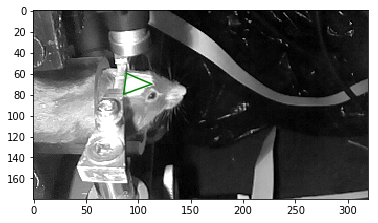

In [25]:
from roipoly import RoiPoly 
import matplotlib.pyplot as plt

%matplotlib qt
plt.imshow(behavior_frames[0], cmap='gray', vmin=0, vmax=255)
roi = RoiPoly(color='g')

# Let's see what we have
%matplotlib inline
plt.imshow(behavior_frames[0], cmap='gray', vmin=0, vmax=255)
roi.display_roi()

### Remove Dark frames where lights go on/off

In [ ]:
behavior_frames_slice = vp.DarkFramesSlice.gradient_method(
    frames=behavior_frames, 
    threshold=5
)
behavior_frames = behavior_frames[behavior_frames_slice]